In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ./cs231n/datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-labels-idx1-ubyte.gz


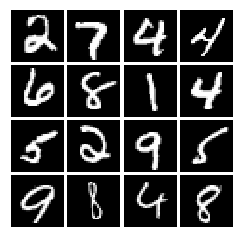

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    a = tf.maximum(x, 0)
    b = tf.maximum(-x, 0)
    return a - b * alpha
    pass


In [4]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns: 
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform(shape = (batch_size, dim), minval = -1, maxval = 1)
    pass


In [6]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(z,1024,activation=tf.nn.relu)
        batch_layer1 = tf.layers.batch_normalization(fc1, training=True)
        fc2 = tf.layers.dense(batch_layer1,7*7*128,activation=tf.nn.relu)
        batch_layer2 = tf.layers.batch_normalization(fc2,training=True)
        reshape = tf.reshape(batch_layer2,(-1,7,7,128))
        conv1 = tf.layers.conv2d_transpose(reshape,64,kernel_size=(4,4),strides=(2,2),padding='same',activation=tf.nn.relu)
        batch_layer3 = tf.layers.batch_normalization(conv1,training=True)
        img = tf.layers.conv2d_transpose(batch_layer3,1,kernel_size=(4,4),strides=(2,2),padding='same',activation=tf.nn.tanh)
        img = tf.reshape(img,(-1,784))
    return img



In [7]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        x = tf.reshape(x, (-1,28,28,1))        
        conv1 = tf.layers.conv2d(x,64,4, strides=2, padding='valid',name = 'conv1')
        relu1 = leaky_relu(conv1)
        conv2 = tf.layers.conv2d(relu1,128,4, strides=2, padding='valid',name='conv2')
        relu2 = leaky_relu(conv2)
        batch_layer = tf.layers.batch_normalization(relu2,training=True)
        flatten = tf.reshape(batch_layer, [-1, 3200])
        fc_layer1 = tf.layers.dense(flatten, 1024,name='fc1')
        relu3 = leaky_relu(fc_layer1)
        logits = tf.layers.dense(relu3, 1,name='fc2')        
        return logits


In [8]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    D_solver=tf.train.AdamOptimizer(learning_rate,beta1)
    G_solver=tf.train.AdamOptimizer(learning_rate,beta1)
    return D_solver, G_solver

In [9]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

In [10]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [11]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake, labels = tf.ones_like(logits_fake))
    G_loss = tf.reduce_mean(G_loss)
    D_loss1 = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_real, labels = tf.ones_like(logits_real))
    D_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake, labels = tf.zeros_like(logits_fake))
    D_loss = D_loss1 + D_loss2
    D_loss = tf.reduce_mean(D_loss)
    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.placeholder(tf.float32, shape=(batch_size, 1, 1, 1))
    x_hat = eps*x+(1.0-eps)*G_sample
    
    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), [x_hat])
    
    grad_norm = tf.norm(grad_D_x_hat[0], ord=2) - 1.0
    grad_pen = lam * tf.square(grad_norm)
    D_loss += grad_pen


    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

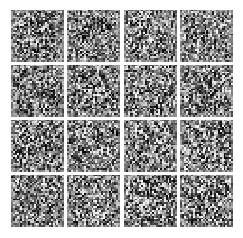

ResourceExhaustedError: OOM when allocating tensor of shape [16384,5,5,128] and type float
	 [[Node: gradients_1/discriminator_2/Maximum_2_grad/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [16384,5,5,128] values: [[[0 0 0]]]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'gradients_1/discriminator_2/Maximum_2_grad/zeros', defined at:
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-fde5a70f9a6b>", line 45, in <module>
    D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\training\optimizer.py", line 343, in minimize
    grad_loss=grad_loss)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\training\optimizer.py", line 414, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 581, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 353, in _MaybeCompile
    return grad_fn()  # Exit early
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 581, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py", line 863, in _MaximumGrad
    return _MaximumMinimumGrad(op, grad, math_ops.greater_equal)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py", line 850, in _MaximumMinimumGrad
    zeros = array_ops.zeros(gradshape, gdtype)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1442, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1770, in fill
    "Fill", dims=dims, value=value, name=name)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'discriminator_2/Maximum_2', defined at:
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-fde5a70f9a6b>", line 44, in <module>
    D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
  File "<ipython-input-11-fde5a70f9a6b>", line 35, in wgangp_loss
    grad_D_x_hat = tf.gradients(discriminator(x_hat), [x_hat])
  File "<ipython-input-7-7d06dd4370dd>", line 8, in discriminator
    relu2 = leaky_relu(conv2)
  File "<ipython-input-3-803712a5c9e0>", line 12, in leaky_relu
    a = tf.maximum(x, 0)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2521, in maximum
    "Maximum", x=x, y=y, name=name)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "c:\users\subhash nerella\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [16384,5,5,128] and type float
	 [[Node: gradients_1/discriminator_2/Maximum_2_grad/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [16384,5,5,128] values: [[[0 0 0]]]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [12]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)